<a href="https://colab.research.google.com/github/EagleVector/BERT/blob/main/BERT_SPAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CONVERTING AN ENTIRE EMAIL INTO A VECTOR (EMBEDDING)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pwd

'/content'

In [3]:
cd /content/drive/MyDrive/Colab Notebooks/root/BERT

/content/drive/MyDrive/Colab Notebooks/root/BERT


## Installing the dependencies

In [4]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [5]:
pip install tensorflow-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 15.2 MB/s 
     |████████████████████████████████| 588.3 MB 16 kB/s 
     |████████████████████████████████| 6.0 MB 43.8 MB/s 
     |████████████████████████████████| 1.7 MB 47.1 MB/s 
     |████████████████████████████████| 439 kB 69.6 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.

## READING THE DATA

In [5]:
import pandas as pd

df = pd.read_csv('email.csv')
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## DATA ANALYSIS

In [6]:
df.Category.value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

THERE IS AN IMBALANCE IN OUR DATA

In [7]:
747/4825

0.15481865284974095

## DATA BALANCING

15% ARE SPAM EMAIL AND REST 85% ARE HAM/IMPORTANT EMAILS

WE WILL DO DOWNSAMPLING USING `pd.sample` TO KEEP IT SIMPLE

In [8]:
df_spam = df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [9]:
df_ham = df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [10]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])

In [11]:
df_balanced = pd.concat([df_spam, df_ham_downsampled])
df_balanced.shape

(1494, 2)

In [12]:
df_balanced.Category.value_counts()

spam    747
ham     747
Name: Category, dtype: int64

In [13]:
df_balanced.sample(5)

,Category,Message
3307,ham,HI DARLIN I FINISH AT 3 DO U 1 2 PICK ME UP OR...
4401,ham,Juz go google n search 4 qet...
2999,ham,No b4 Thursday
4475,spam,Want explicit SEX in 30 secs? Ring 02073162414...
1477,ham,I'm watching lotr w my sis dis aft. So u wan 2...


In [14]:
df_balanced['spam'] = df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
5004,spam,CDs 4u: Congratulations ur awarded £500 of CD ...,1
690,spam,<Forwarded from 448712404000>Please CALL 08712...,1
2478,ham,I'm done. I'm sorry. I hope your next space gi...,0
4993,ham,I'm hungry buy smth home...,0
5232,spam,YOU ARE CHOSEN TO RECEIVE A £350 AWARD! Pls ca...,1


## TRAIN-TEST SPLIT

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'], df_balanced['spam'], stratify= df_balanced['spam'])

In [16]:
X_train.head()

2728                  Whatsup there. Dont u want to sleep
4527    I want some cock! My hubby's away, I need a re...
4574    URGENT! This is the 2nd attempt to contact U!U...
4019         GRAN ONLYFOUND OUT AFEW DAYS AGO.CUSOON HONI
1324    I thk 50 shd be ok he said plus minus 10.. Did...
Name: Message, dtype: object

## BERT

LOADING BERT MODEL FOR OUR SPAM DETECTION MODEL

In [17]:
bert_preprocess = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

In [18]:
def get_sentence_embedding(sentences):
  preprocessed_text = bert_preprocess(sentences)
  return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embedding(['500$ in cash! Win Lottery worth crores',
                        'Meeting scheduled for tomorrow',
                        'Superbowl game night at 8',
                        'Monthly electricity bill for May: 200$'])

<tf.Tensor: shape=(4, 768), dtype=float32, numpy=
array([[-0.8854935 , -0.6805188 , -0.9772354 , ..., -0.934041  ,
        -0.7394153 ,  0.90679854],
       [-0.91557074, -0.38290426, -0.4145114 , ..., -0.13639641,
        -0.65285075,  0.9363188 ],
       [-0.8404849 , -0.503439  , -0.8383499 , ..., -0.24353634,
        -0.7408734 ,  0.912364  ],
       [-0.6105864 , -0.2994521 , -0.6612465 , ..., -0.53991544,
        -0.6378382 ,  0.82045877]], dtype=float32)>

EMBEDDINGS GENERATED FOR OUR 4 STATEMENTS

LETS CHECK THE COSINE SIMILARITIES BETWEEN THE STATEMENTS.

In [19]:
mail = get_sentence_embedding(['500$ in cash! Win Lottery worth crores',
                        'Meeting scheduled for tomorrow',
                        'Superbowl game night at 8',
                        'Monthly electricity bill for May: 200$',
                        'SPAM',
                        'IMPORTANT',
                        'SPAM'])

In [20]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity([mail[0]], [mail[5]])

array([[0.5110344]], dtype=float32)

COSINE SIMILARITY DEPICTS THE VECTOR ANGLE. HOW SIMILAR THE TENSORS ARE.

## MODEL BUILDING

FUNCTIONAL MODEL

BERT LAYERS

In [21]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


NEURAL NETWORK LAYERS

In [22]:
l = tf.keras.layers.Dropout(0.1, name='dropout')(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(l)

CONSTRUCTING THE FINAL MODEL

In [23]:
model = tf.keras.Model(inputs=[text_input], outputs=[l])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

ALL THE TRAINABLE PARAMS ARE COMING FROM BERT. REST WE ARE TRAINING.

## MODEL TRAINING

WE ARE DEFINING THE METRICES BY OUR OWN

In [24]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precison'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [25]:
model.fit(X_train, y_train, epochs=5)

Epoch 1/5
35/35 [==============================] - 481s 13s/step - loss: 0.6541 - accuracy: 0.6071 - precison: 0.6141 - recall: 0.5768
Epoch 2/5
35/35 [==============================] - 468s 13s/step - loss: 0.5236 - accuracy: 0.7830 - precison: 0.7620 - recall: 0.8232
Epoch 3/5
35/35 [==============================] - 474s 14s/step - loss: 0.4555 - accuracy: 0.8402 - precison: 0.8432 - recall: 0.8357
Epoch 4/5
35/35 [==============================] - 476s 14s/step - loss: 0.3971 - accuracy: 0.8777 - precison: 0.8653 - recall: 0.8946
Epoch 5/5
35/35 [==============================] - 474s 14s/step - loss: 0.3646 - accuracy: 0.8732 - precison: 0.8591 - recall: 0.8929


In [26]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 163s 13s/step - loss: 0.3682 - accuracy: 0.8850 - precison: 0.8396 - recall: 0.9519


[0.36824068427085876,
 0.885026752948761,
 0.8396226167678833,
 0.9518716335296631]

In [27]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

12/12 [==============================] - 159s 13s/step


In [28]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,

In [29]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[153,  34],
       [  9, 178]])

Text(33.0, 0.5, 'Truth')

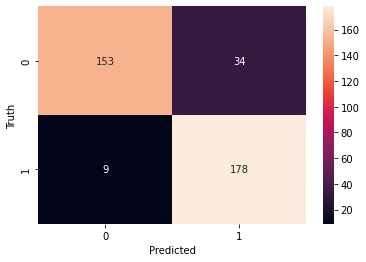

In [30]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')


In [31]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.94      0.82      0.88       187
           1       0.84      0.95      0.89       187

    accuracy                           0.89       374
   macro avg       0.89      0.89      0.88       374
weighted avg       0.89      0.89      0.88       374



## INFERENCE

In [36]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 2s 2s/step


array([[0.72212636],
       [0.739123  ],
       [0.76375264],
       [0.31307963],
       [0.19572549]], dtype=float32)

In [33]:
model.save("saved_models/1/")

In [34]:
model.save("saved_models/2/")

In [42]:
model.save("saved_models/3/")